In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = "data/client_mapping.csv"
    freight_mapping_file = "data/freight_mapping.csv"
    station_mapping_file = "data/station_mapping.csv"

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df

def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"


    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    fact = add_master_data_mappings(fact)
    forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True)
    ).sum()/summary["Forecast Accuracy"].shape[0]

    return score

## Валидация

In [3]:
dt = pd.read_csv(
        'data/fact_train_test.csv',
        sep=";",
        decimal=",",
        encoding="windows-1251",
        parse_dates=['period']
    )

In [4]:
dt = add_master_data_mappings(dt)

In [5]:
dt = dt[dt['period']>'2017-01-01']
dt['month'] = dt['period'].dt.month
dt

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,month
44750,2017-02-01,0,0,0,-1,3505,4893,3645,7241,66.0,1,NaN,4,58,13,130,25,2
44751,2017-02-01,0,0,0,-1,23,11020,37638,672,32.0,0,NaN,5,97,23,55,3,2
44752,2017-02-01,0,0,0,-1,23,11020,37638,4946,37.0,0,NaN,5,97,23,55,3,2
44753,2017-02-01,0,0,0,-1,4133,11020,37638,672,2.0,1,NaN,18,97,23,55,3,2
44754,2017-02-01,0,0,0,-1,4228,11020,37638,672,15.0,0,NaN,18,97,23,55,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1,2226.0,22,73,14,143,35,3
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1,2226.0,22,73,14,79,10,3
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1,2226.0,22,73,14,104,10,3
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3,2226.0,22,73,14,143,35,3


## Валидация с 2022-11-01

In [6]:
train = dt[dt['period']<'2022-11-01']
val = dt[dt['period']>='2022-11-01']



## Делаем "Эмбединги": матрицы sender_station <-> sender organisation

Это позволит агрегировать информацию попарных соответсвий между отправителем и адресатом. 
Далее используем PCA для снижения размерности

In [7]:
matrix_wagons_train = pd.pivot_table(train, values='real_wagon_count', index='sender_station_id',
                       columns='sender_organisation_id', aggfunc="mean").fillna(0)


matrix_wagons_train

sender_organisation_id,0,1,2,3,5,6,8,9,10,11,...,34527,34528,34529,34530,34531,34532,34533,34534,34535,34536
sender_station_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39105,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
matrix_weight_train = pd.pivot_table(train, values='month', index='sender_station_id',
                       columns='sender_organisation_id', aggfunc="mean").fillna(0)


matrix_weight_train

sender_organisation_id,0,1,2,3,5,6,8,9,10,11,...,34527,34528,34529,34530,34531,34532,34533,34534,34535,34536
sender_station_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39105,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
matrix_podrod_train = pd.pivot_table(train, values='podrod', index='sender_station_id',
                       columns='sender_organisation_id', aggfunc=(lambda x:mode(x).mode[0])).fillna(0)


matrix_podrod_train

C:\Users\AAAA\AppData\Local\Temp\ipykernel_11256\707019728.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  columns='sender_organisation_id', aggfunc=(lambda x:mode(x).mode[0])).fillna(0)


sender_organisation_id,0,1,2,3,5,6,8,9,10,11,...,34527,34528,34529,34530,34531,34532,34533,34534,34535,34536
sender_station_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39105,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
a = []
b = []
c = []

for i in range(69):
    a.append('1_'+str(i))
    b.append('2_'+str(i))
    c.append('3_'+str(i))

In [11]:
train_PCA1 = StandardScaler().fit_transform(matrix_wagons_train)
train_PCA2 = StandardScaler().fit_transform(matrix_weight_train)
train_PCA3 = StandardScaler().fit_transform(matrix_podrod_train)

train_PCA1 = PCA(n_components=69, random_state=4221).fit_transform(train_PCA1)
train_PCA2 = PCA(n_components=69, random_state=4221).fit_transform(train_PCA2)
train_PCA3 = PCA(n_components=69, random_state=4221).fit_transform(train_PCA3)

    
train_PCAall = pd.concat([
    pd.DataFrame(matrix_podrod_train.index),
    pd.DataFrame(train_PCA1, columns=a), 
    pd.DataFrame(train_PCA2, columns=b), 
    pd.DataFrame(train_PCA3, columns=c)], axis=1)
train_PCAall

,sender_station_id,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,3_59,3_60,3_61,3_62,3_63,3_64,3_65,3_66,3_67,3_68
0,0,-0.513907,-0.547232,-0.466014,-0.422932,-0.339473,-0.347449,-0.501910,-0.600405,-0.375287,...,0.330987,0.478912,2.937409,2.481385,-0.295187,-1.038864,-2.160059,-1.514749,5.334240,-0.049831
1,743,-0.563751,-0.481718,-0.414201,-0.410783,-0.287170,-0.311600,-0.446905,-0.670593,-0.303792,...,8.871417,-21.485891,-44.561739,63.080101,29.859649,-59.197492,-6.155073,1.393738,-137.276377,-64.946804
2,777,-0.434029,-0.365032,-0.286216,-0.270494,-0.188674,-0.207942,-0.293710,-0.352359,-0.236840,...,-0.115288,-0.118381,0.326213,-0.047446,0.156718,-0.178192,-0.131456,0.201794,0.074929,-0.103126
3,790,-0.424594,-0.355389,-0.277746,-0.262263,-0.182790,-0.201242,-0.284198,-0.338542,-0.226921,...,-0.114342,-0.096267,0.296796,-0.051801,0.143076,-0.162752,-0.132474,0.194628,0.070908,-0.096296
4,803,-0.431810,-0.362796,-0.284128,-0.268291,-0.187356,-0.206353,-0.291271,-0.348091,-0.234901,...,-0.122658,-0.124597,0.333294,-0.051010,0.161230,-0.182409,-0.135689,0.206781,0.074644,-0.104228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,39089,-0.437054,1.048504,-0.291540,-0.286337,-0.223147,0.995686,-0.078150,-0.394960,-0.193504,...,-0.046836,-0.656492,-0.048729,-1.111073,-0.060275,-0.589646,-0.419660,-1.369891,0.453405,1.393247
3205,39104,-0.422832,-0.353665,-0.276159,-0.260736,-0.181894,-0.200111,-0.282442,-0.336394,-0.225017,...,-0.109772,-0.112264,0.301790,-0.047876,0.145497,-0.162916,-0.122220,0.184486,0.065868,-0.093727
3206,39105,-0.429876,-0.354165,-0.282374,-0.267423,-0.187090,-0.201323,-0.288900,-0.346375,-0.234775,...,-0.085053,-0.090213,0.305496,-0.016534,0.151667,-0.158316,-0.126554,0.174034,0.119478,-0.061167
3207,39114,-0.428664,-0.303665,-0.281393,-0.266069,-0.186905,-0.139006,-0.276012,-0.345660,-0.228510,...,-0.118558,-0.158989,0.290922,-0.135167,0.136729,-0.209171,-0.150733,0.071427,0.091117,0.025244


In [12]:
train = train.merge(train_PCAall, how='left', on='sender_station_id')
train

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,...,3_59,3_60,3_61,3_62,3_63,3_64,3_65,3_66,3_67,3_68
0,2017-02-01,0,0,0,-1,3505,4893,3645,7241,66.0,...,-0.118397,-0.120534,0.322973,-0.050047,0.156062,-0.175954,-0.131250,0.199384,0.071706,-0.100776
1,2017-02-01,0,0,0,-1,23,11020,37638,672,32.0,...,-0.151192,-0.130799,0.379337,-0.021039,0.147551,-0.214871,-0.176268,0.254289,0.096452,-0.130817
2,2017-02-01,0,0,0,-1,23,11020,37638,4946,37.0,...,-0.151192,-0.130799,0.379337,-0.021039,0.147551,-0.214871,-0.176268,0.254289,0.096452,-0.130817
3,2017-02-01,0,0,0,-1,4133,11020,37638,672,2.0,...,-0.151192,-0.130799,0.379337,-0.021039,0.147551,-0.214871,-0.176268,0.254289,0.096452,-0.130817
4,2017-02-01,0,0,0,-1,4228,11020,37638,672,15.0,...,-0.151192,-0.130799,0.379337,-0.021039,0.147551,-0.214871,-0.176268,0.254289,0.096452,-0.130817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295649,2022-10-01,1,5,2,690,1180,23677,33108,26824,264.0,...,7.159745,-3.841122,-3.096021,-6.914788,-1.820787,-9.041149,0.566667,5.674159,3.680063,-5.004766
3295650,2022-10-01,1,5,2,690,1180,23677,33120,26824,204.0,...,7.159745,-3.841122,-3.096021,-6.914788,-1.820787,-9.041149,0.566667,5.674159,3.680063,-5.004766
3295651,2022-10-01,1,5,2,690,1180,23677,32975,26824,332.0,...,7.159745,-3.841122,-3.096021,-6.914788,-1.820787,-9.041149,0.566667,5.674159,3.680063,-5.004766
3295652,2022-10-01,1,5,2,690,1180,23677,20404,26824,908.0,...,7.159745,-3.841122,-3.096021,-6.914788,-1.820787,-9.041149,0.566667,5.674159,3.680063,-5.004766


In [13]:
val = val.merge(train_PCAall, how='left', on='sender_station_id')

In [14]:
val['holding_name'] = val['holding_name'].fillna(-111).astype(int)
train['holding_name'] = train['holding_name'].fillna(-111).astype(int)
val['holding_name'] 

0         -111
1         -111
2         -111
3         -111
4         -111
          ... 
218823    2226
218824    2226
218825    2226
218826    2226
218827    2226
Name: holding_name, Length: 218828, dtype: int32

## Обучаем 2 модели
1. Классификатор, определющий будет ли значение предикта равно 1, или больше
2. Ргерассор для значений больше одного

In [15]:
cat = ['rps', 'podrod', 'filial', 'month', 'freight_group_name']
train_pool = cb.Pool(train.drop(['real_wagon_count', 'real_weight'], axis=1), 
                     label=train['real_wagon_count'] == 1, 
                     timestamp=train['period'], cat_features=cat)


val_pool = cb.Pool(val.drop(['real_wagon_count', 'real_weight'], axis=1), 
                   label=val['real_wagon_count'] == 1, timestamp=val['period'], cat_features=cat)

In [16]:
model_cls = cb.CatBoostClassifier(random_seed=4221,  iterations=3000, early_stopping_rounds=100,
                            loss_function='Logloss', task_type='GPU', eval_metric='AUC', auto_class_weights='Balanced')
model_cls.fit(train_pool, eval_set=val_pool, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.022697


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6720385	best: 0.6720385 (0)	total: 174ms	remaining: 8m 41s
100:	test: 0.7109650	best: 0.7109650 (100)	total: 16.4s	remaining: 7m 50s
200:	test: 0.7197935	best: 0.7197935 (200)	total: 33.9s	remaining: 7m 52s
300:	test: 0.7240812	best: 0.7240812 (300)	total: 51.1s	remaining: 7m 38s
400:	test: 0.7278980	best: 0.7278980 (400)	total: 1m 8s	remaining: 7m 24s
500:	test: 0.7306679	best: 0.7306679 (500)	total: 1m 26s	remaining: 7m 9s
600:	test: 0.7331558	best: 0.7331558 (600)	total: 1m 43s	remaining: 6m 53s
700:	test: 0.7352494	best: 0.7352494 (700)	total: 2m 1s	remaining: 6m 37s
800:	test: 0.7370570	best: 0.7370570 (800)	total: 2m 19s	remaining: 6m 22s
900:	test: 0.7388103	best: 0.7388103 (900)	total: 2m 37s	remaining: 6m 6s
1000:	test: 0.7403660	best: 0.7403660 (1000)	total: 2m 55s	remaining: 5m 50s
1100:	test: 0.7417039	best: 0.7417039 (1100)	total: 3m 13s	remaining: 5m 33s
1200:	test: 0.7431361	best: 0.7431361 (1200)	total: 3m 31s	remaining: 5m 17s
1300:	test: 0.7444034	best: 0.7

In [17]:
train_reg = train[train['real_wagon_count']>1]
train_val = train[train['real_wagon_count']>1]


cat = ['rps', 'podrod', 'filial', 'month', 'freight_group_name']
train_pool_reg = cb.Pool(train_reg.drop(['real_wagon_count', 'real_weight'], axis=1), 
                     label=train_reg['real_wagon_count'], 
                     timestamp=train_reg['period'], cat_features=cat)


val_pool_reg = cb.Pool(train_val.drop(['real_wagon_count', 'real_weight'], axis=1), 
                   label=train_val['real_wagon_count'], timestamp=train_val['period'], cat_features=cat)

In [18]:
model_reg = cb.CatBoostRegressor(random_seed=4221,  iterations=1500, early_stopping_rounds=100,
                            loss_function='Poisson', task_type='GPU')
model_reg.fit(train_pool_reg, eval_set=val_pool_reg, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6784590	test: 0.6784591	best: 0.6784591 (0)	total: 118ms	remaining: 2m 57s
100:	learn: -112.7223107	test: -112.7352450	best: -112.7352450 (100)	total: 11s	remaining: 2m 33s
200:	learn: -118.8799178	test: -118.8937863	best: -118.8937863 (200)	total: 21.9s	remaining: 2m 21s
300:	learn: -122.0097156	test: -121.9935880	best: -121.9935880 (300)	total: 33.3s	remaining: 2m 12s
400:	learn: -124.2132766	test: -124.1947626	best: -124.1947626 (400)	total: 45.4s	remaining: 2m 4s
500:	learn: -125.7783326	test: -125.7512919	best: -125.7512919 (500)	total: 57.5s	remaining: 1m 54s
600:	learn: -126.8314671	test: -126.7945834	best: -126.7945834 (600)	total: 1m 9s	remaining: 1m 44s
700:	learn: -127.6948411	test: -127.6295155	best: -127.6295155 (700)	total: 1m 22s	remaining: 1m 33s
800:	learn: -128.5183336	test: -128.4242942	best: -128.4242942 (800)	total: 1m 35s	remaining: 1m 23s
900:	learn: -129.2216292	test: -129.1084982	best: -129.1084982 (900)	total: 1m 49s	remaining: 1m 12s
1000:	learn: 

## Прогнозируем:
1. Для значений 1 прогнозируем классификаторм
2. Для остальных значений - регрессором

In [19]:
val_0 = pd.read_csv(
        'data/fact_train_test.csv',
        sep=";",
        decimal=",",
        encoding="windows-1251",
        parse_dates=['period']
    )


val_0 = val_0[val_0['period']>='2022-11-01']

fcst = val_0.copy()
fcst['forecast_wagon_count1'] = model_cls.predict_proba(val_pool)[:,1]
fcst['forecast_wagon_count2'] = model_reg.predict(val_pool)

good = []
for true, bad in zip(fcst['forecast_wagon_count1'],fcst['forecast_wagon_count2'] ):
    if true > 0.5:
        good.append(true)
        
    else:
        good.append(bad)
        
fcst['forecast_wagon_count'] = good
fcst['forecast_wagon_count'] = np.round(fcst['forecast_wagon_count']).astype('int')

In [20]:
evaluate(fact = val_0, forecast = fcst)


0.597423178215682

Text(0.5, 1.0, 'Feature Importance')

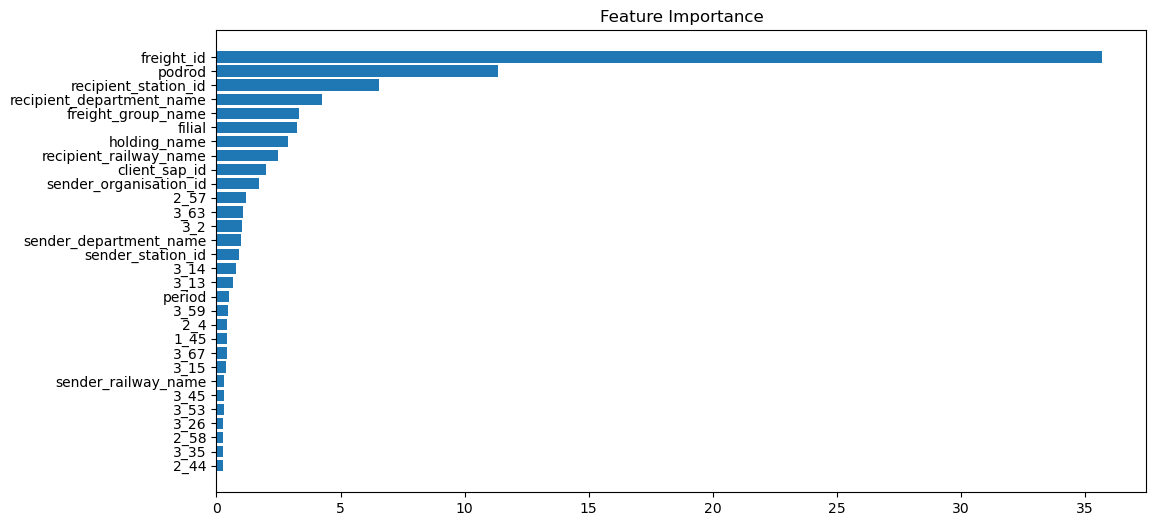

In [22]:

feature_importance = model_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)[-30:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.drop(['real_wagon_count', 'real_weight'], axis=1).columns)[sorted_idx])
plt.title('Feature Importance')


## Все данные (для сабмита)

In [23]:
dt = pd.read_csv(
        'data/fact_train_test.csv',
        sep=";",
        decimal=",",
        encoding="windows-1251",
        parse_dates=['period']
    )



In [24]:
dt = dt[dt['real_wagon_count']!=0]
dt['month'] = dt['period'].dt.month
dt = add_master_data_mappings(dt)

In [25]:
dt['real_wagon_count']

0          1
1          3
2          1
3          1
4          1
          ..
3349911    1
3349912    1
3349913    1
3349914    3
3349915    1
Name: real_wagon_count, Length: 3349916, dtype: int64

In [26]:
val = pd.read_csv(
        'data/forecast_example.csv',
        sep=";",
        decimal=",",
        encoding="windows-1251",
    parse_dates=['period']
    )

In [27]:
val['month'] = val['period'].dt.month
val = add_master_data_mappings(val)
val

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count,month,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,73.0,1,4,13.0,20,77,31,124,5
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,146.0,2,4,13.0,20,77,31,124,5
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,876.0,12,4,13.0,20,77,31,147,31
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,473.0,7,4,NaN,10,23,6,23,6
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,63.0,1,4,NaN,10,23,6,23,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,69.0,1,8,2226.0,22,73,14,143,35
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,70.0,1,8,2226.0,22,73,14,79,10
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,70.0,1,8,2226.0,22,73,14,104,10
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,207.0,3,8,2226.0,22,73,14,143,35


In [28]:
matrix_wagons_train = pd.pivot_table(dt, values='real_wagon_count', index='sender_station_id',
                       columns='sender_organisation_id', aggfunc="mean").fillna(0)

matrix_weight_train = pd.pivot_table(dt, values='month', index='sender_station_id',
                       columns='sender_organisation_id', aggfunc="mean").fillna(0)

matrix_podrod_train = pd.pivot_table(dt, values='podrod', index='sender_station_id',
                       columns='sender_organisation_id', aggfunc=(lambda x:mode(x).mode[0])).fillna(0)

C:\Users\AAAA\AppData\Local\Temp\ipykernel_11256\4068966523.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  columns='sender_organisation_id', aggfunc=(lambda x:mode(x).mode[0])).fillna(0)


In [29]:
a = []
b = []
c = []

for i in range(69):
    a.append('1_'+str(i))
    b.append('2_'+str(i))
    c.append('3_'+str(i))

In [30]:
train_PCA1 = StandardScaler().fit_transform(matrix_wagons_train)
train_PCA2 = StandardScaler().fit_transform(matrix_weight_train)
train_PCA3 = StandardScaler().fit_transform(matrix_podrod_train)

train_PCA1 = PCA(n_components=69, random_state=4221).fit_transform(train_PCA1)
train_PCA2 = PCA(n_components=69, random_state=4221).fit_transform(train_PCA2)
train_PCA3 = PCA(n_components=69, random_state=4221).fit_transform(train_PCA3)

    
train_PCAall = pd.concat([
    pd.DataFrame(matrix_podrod_train.index),
    pd.DataFrame(train_PCA1, columns=a), 
    pd.DataFrame(train_PCA2, columns=b), 
    pd.DataFrame(train_PCA3, columns=c)], axis=1)
train_PCAall

,sender_station_id,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,3_59,3_60,3_61,3_62,3_63,3_64,3_65,3_66,3_67,3_68
0,0,-0.580917,-0.622017,-0.527301,-0.319397,-0.437171,-0.429862,-0.473273,-0.757804,-0.338569,...,-5.416831,-1.136210,3.075042,-1.760201,0.314699,-1.037938,0.404521,5.276331,1.981025,1.060471
1,743,-0.200516,-0.520140,-0.452274,-0.399660,-0.380226,-0.375482,-0.381533,-0.565994,-0.265092,...,17.162697,-34.855078,17.537487,-1.157460,35.859420,-8.459685,20.610873,16.418038,-37.184194,-27.960899
2,777,-0.459551,-0.391819,-0.311986,-0.167579,-0.255568,-0.256260,-0.250550,-0.365182,-0.250198,...,-0.244241,0.259839,0.169392,-0.064733,0.045930,-0.189257,-0.104004,-0.251688,-0.169367,0.045503
3,790,-0.450998,-0.382167,-0.303409,-0.162413,-0.248341,-0.248867,-0.242700,-0.352392,-0.241654,...,-0.240751,0.239145,0.159380,-0.063556,0.044624,-0.169020,-0.100494,-0.238321,-0.161077,0.042039
4,803,-0.459964,-0.391432,-0.311491,-0.166901,-0.255142,-0.255937,-0.250032,-0.364735,-0.251051,...,-0.269301,0.265683,0.178083,-0.072220,0.053807,-0.185691,-0.113427,-0.266127,-0.182150,0.043016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3251,39089,-0.464039,1.027700,-0.317164,-0.201347,-0.281316,0.859539,-0.253640,-0.398680,-0.211789,...,0.079013,0.415661,-0.100129,-0.597033,0.487603,0.229831,-0.217772,-0.141814,-0.143541,-0.051653
3252,39104,-0.449161,-0.380307,-0.301851,-0.161553,-0.246923,-0.247483,-0.241159,-0.350077,-0.239729,...,-0.239282,0.235117,0.156476,-0.064700,0.044105,-0.165232,-0.099940,-0.234117,-0.161687,0.040223
3253,39105,-0.458014,-0.383188,-0.310347,-0.165131,-0.254839,-0.250056,-0.248243,-0.363493,-0.250817,...,-0.200465,0.264308,0.130547,-0.078825,0.091006,-0.205027,-0.109926,-0.289906,-0.154881,0.041327
3254,39114,-0.455023,-0.329288,-0.307114,-0.165899,-0.252330,-0.191015,-0.245880,-0.359075,-0.243180,...,-0.235622,0.253225,0.151441,-0.107247,0.083350,-0.145175,-0.115115,-0.236306,-0.166935,0.035924


In [31]:
train = dt.merge(train_PCAall, how='left', on='sender_station_id')
val = val.merge(train_PCAall, how='left', on='sender_station_id')

In [32]:
val['holding_name'] = val['holding_name'].fillna(-111).astype(int)
train['holding_name'] = train['holding_name'].fillna(-111).astype(int)
val['holding_name'] 

0           13
1           13
2           13
3         -111
4         -111
          ... 
239600    2226
239601    2226
239602    2226
239603    2226
239604    2226
Name: holding_name, Length: 239605, dtype: int32

In [33]:
cat = ['rps', 'podrod', 'filial', 'month', 'freight_group_name']
train_pool_cls = cb.Pool(train.drop(['real_wagon_count', 'real_weight'], axis=1), 
                     label=train['real_wagon_count']==1, timestamp=train['period'], cat_features=cat)

In [35]:
model_cls = cb.CatBoostClassifier(random_seed=4221,  iterations=3000,
                            loss_function='Logloss', task_type='GPU', auto_class_weights='Balanced')
model_cls.fit(train_pool_cls, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.008061
0:	learn: 0.6918414	total: 188ms	remaining: 9m 23s
100:	learn: 0.6290199	total: 17.3s	remaining: 8m 16s
200:	learn: 0.6128045	total: 33.7s	remaining: 7m 49s
300:	learn: 0.6059097	total: 49.9s	remaining: 7m 27s
400:	learn: 0.6022499	total: 1m 7s	remaining: 7m 19s
500:	learn: 0.5995363	total: 1m 26s	remaining: 7m 9s
600:	learn: 0.5974007	total: 1m 44s	remaining: 6m 57s
700:	learn: 0.5956173	total: 2m 3s	remaining: 6m 44s
800:	learn: 0.5940897	total: 2m 22s	remaining: 6m 30s
900:	learn: 0.5926967	total: 2m 41s	remaining: 6m 16s
1000:	learn: 0.5913983	total: 3m 1s	remaining: 6m 3s
1100:	learn: 0.5902429	total: 3m 23s	remaining: 5m 50s
1200:	learn: 0.5891456	total: 3m 44s	remaining: 5m 36s
1300:	learn: 0.5881319	total: 4m 5s	remaining: 5m 20s
1400:	learn: 0.5871980	total: 4m 26s	remaining: 5m 4s
1500:	learn: 0.5862974	total: 4m 47s	remaining: 4m 47s
1600:	learn: 0.5854593	total: 5m 10s	remaining: 4m 31s
1700:	learn: 0.5846107	total: 5m 33s	remaining: 4m 14s
180

In [36]:
cat = ['rps', 'podrod', 'filial', 'month', 'freight_group_name']

train_reg = train[train['real_wagon_count']>1]


train_pool_reg = cb.Pool(train_reg.drop(['real_wagon_count', 'real_weight'], axis=1), 
                     label=train_reg['real_wagon_count'], timestamp=train_reg['period'], cat_features=cat)

In [37]:
model_reg = cb.CatBoostRegressor(random_seed=4221,  iterations=1500,
                            loss_function='Poisson', task_type='GPU', learning_rate=0.3)
model_reg.fit(train_pool_reg, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: -2.2767030	total: 151ms	remaining: 3m 46s
100:	learn: -130.1797656	total: 12.1s	remaining: 2m 47s
200:	learn: -133.6368864	total: 25.2s	remaining: 2m 42s
300:	learn: -135.2783452	total: 38.8s	remaining: 2m 34s
400:	learn: -136.3643706	total: 53.2s	remaining: 2m 25s
500:	learn: -137.1241280	total: 1m 7s	remaining: 2m 14s
600:	learn: -137.7011187	total: 1m 21s	remaining: 2m 2s
700:	learn: -138.1301772	total: 1m 35s	remaining: 1m 48s
800:	learn: -138.5072748	total: 1m 49s	remaining: 1m 35s
900:	learn: -138.8384294	total: 2m 3s	remaining: 1m 22s
1000:	learn: -139.1223996	total: 2m 17s	remaining: 1m 8s
1100:	learn: -139.3866822	total: 2m 31s	remaining: 55s
1200:	learn: -139.6222268	total: 2m 46s	remaining: 41.4s
1300:	learn: -139.8108070	total: 3m	remaining: 27.6s
1400:	learn: -139.9873829	total: 3m 14s	remaining: 13.8s
1499:	learn: -140.1540444	total: 3m 29s	remaining: 0us


In [38]:
test_pool = cb.Pool(val.drop(['forecast_wagon_count', 'forecast_weight'], axis=1), 
                    timestamp=val['period'], cat_features=cat)

In [39]:
preds_cls = model_cls.predict_proba(test_pool)
preds_reg = model_reg.predict(test_pool)

In [40]:
val['forecast_wagon_count1'] = preds_cls[:,1]
val['forecast_wagon_count2'] = preds_reg

In [41]:
good = []
for true, bad in zip(val['forecast_wagon_count1'],val['forecast_wagon_count2'] ):
    if true > 0.5:
        good.append(1)
        
    else:
        good.append(bad)

In [42]:
val['forecast_wagon_count_'] = good

val['forecast_wagon_count'] = np.round(val['forecast_wagon_count'])

val['forecast_wagon_count'] = val['forecast_wagon_count'].astype('int')

In [43]:
out = ['period',
'rps',
'podrod',
'filial',
'client_sap_id',
'freight_id',
'sender_station_id',
'recipient_station_id',
'sender_organisation_id',
'forecast_weight',
'forecast_wagon_count'
]

In [44]:
to_predict = val[out]
to_predict

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,73.0,1
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,146.0,2
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,876.0,12
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,473.0,7
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,63.0,1
...,...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,69.0,1
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,70.0,1
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,70.0,1
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,207.0,3


In [ ]:
to_predict.to_csv('preds/poisson_cls_poisson.csv', 
            sep=";",
            decimal=",",
            encoding="windows-1251",
            index=False)